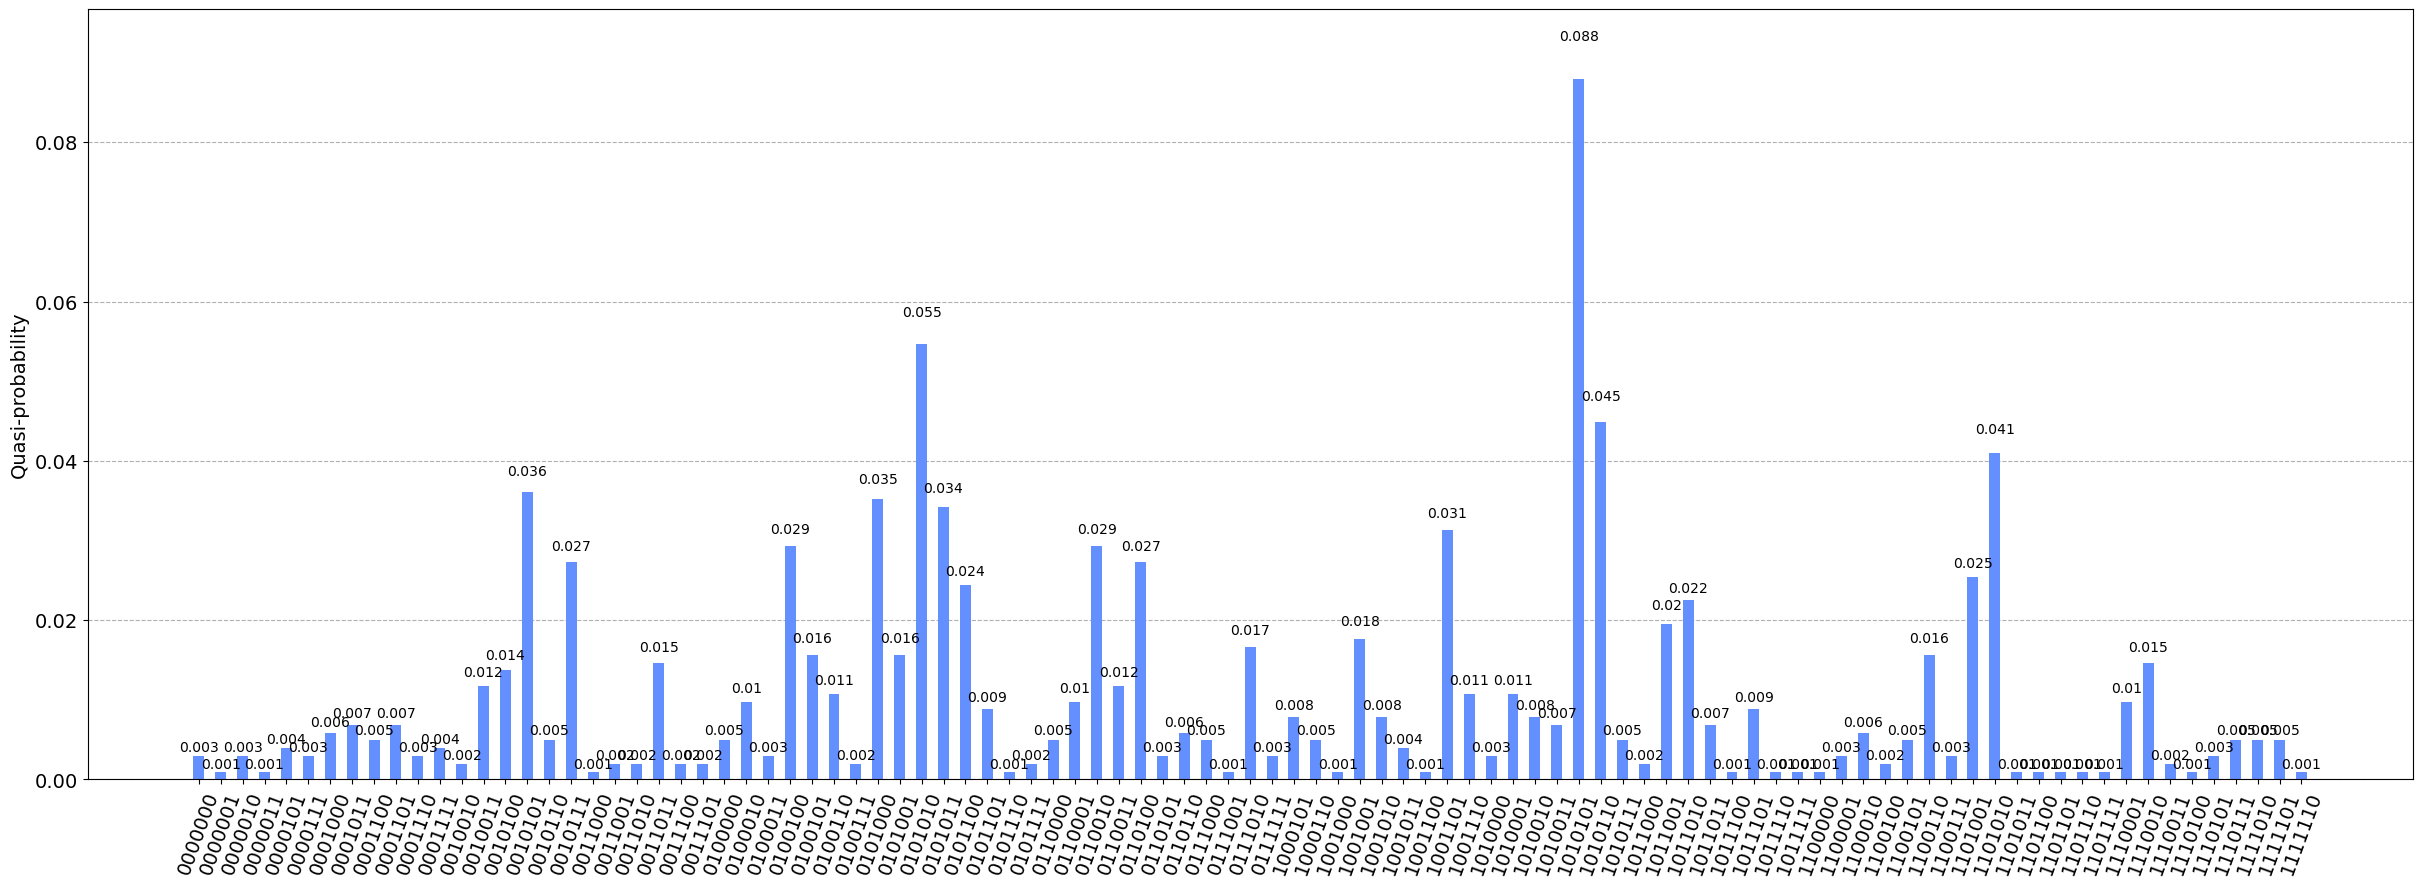

In [3]:
# General imports
import numpy as np

import qiskit
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

from scipy.optimize import minimize

from qiskit import Aer
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_aer.primitives import Sampler as AerSampler



hamiltonian = SparsePauliOp.from_list([("IIIIIZZ", 1), ("IZIIIIZ", 1), ("ZIIIIZZ", 1), ("IIIIZZI", 1), ("IIIZZII", 1), ("IZIIZII", 1), ("IIZZIII", 1), ("IZZIIII", 1), ("ZZIIIII", 1)])
# QAOA ansatz circuit
ansatz = QAOAAnsatz(hamiltonian, reps=2)

# Local Simulator as the backend, we use aersim to find optimal parameter
Aerbackend = Aer.get_backend('aer_simulator')


from qiskit.transpiler import PassManager
from qiskit.transpiler.preset_passmanagers import level_0_pass_manager
from qiskit.transpiler.passes import Unroller, BasisTranslator, NoiseAdaptiveLayout, Optimize1qGates, Decompose


# Create a custom PassManager with specific passes suitable for Aer simulation
pass_manager = PassManager()
pass_manager.append([Unroller(['u1', 'u2', 'u3', 'cx']),
                    Optimize1qGates(), Decompose(Aerbackend)])  # Add more passes as needed

# Apply the passes to your circuit
ansatz_optimized = pass_manager.run(ansatz)


def cost_func(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost


estimator = AerEstimator()
sampler = AerSampler()
x0 = 2 * np.pi * np.random.rand(ansatz_optimized.num_parameters)
res = minimize(cost_func, x0, args=(ansatz_optimized, hamiltonian, estimator), method="COBYLA")

# Assign solution parameters to ansatz
qc = ansatz.assign_parameters(res.x)
# Add measurements to our circuit
qc.measure_all()

# Sample ansatz at optimal parameters
samp_dist = sampler.run(qc).result().quasi_dists[0]
# Close the session since we are now done with it

plot_distribution(samp_dist.binary_probabilities(), figsize=(30, 10))